# Regression analysis



In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
from matplotlib import pyplot as plt
import glob
import scipy
from modules import *

%load_ext autoreload
%autoreload 2

# Preprocessing

We want to apply the following to the data:

    1) Find the anomalies
    2) Get the annual average
    3) Normalise the indepenant variables

In [2]:
files = glob.glob('processed_data/*')
files = [f for f in files if '_' not in f.split('\\')[1]]
ds = xr.open_mfdataset(files)

In [3]:
ds = (ds
      .pipe(w5.find_anomalies)
      .pipe(w5.yearly_average)
      .pipe(w5.normalise_indepenant, dependant='sic')
     ).compute()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

ds = ds.sel(time=slice('1979-01-01','2019-12-31'))               

In [4]:
ds

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    si10     (time, y, x) float64 nan nan nan nan ... 2.163 2.142 2.112 2.061
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    skt      (time, y, x) float64 nan nan nan nan ... -1.194 -1.228 -1.27 -1.4
    sp       (time, y, x) float64 nan nan nan nan ... 0.02288 0.05956 0.09667
    ssr      (time, y, x) float64 nan nan nan nan ... -0.446 -0.3994 -0.3095
    ssrd     (time, y, x) float64 nan nan nan nan ... -0.4259 -0.3814 -0.2936
    sst      (time, y, x) float64 nan nan nan nan ... -1.197 -1.23 -1.271 -1.403
    t2m      (time, y, x) float64 nan nan nan nan ... -1.457 -1.485 -1.541
    u10      (time, y, x) float64 nan nan nan nan ... 2.583 2.575 2.564 2.548
    v10      (time, y, x) float64 nan nan nan nan ... -0.5386 -0.5318 -0.5285

# Correlations

In [5]:
v = [v for v in ds]
correlation_matrix = pd.DataFrame(index=v,columns=v, dtype=np.float64)
for v1,v2 in tqdm(list(itertools.product(v,v))):
    vec1 = ds[v1].mean(dim=('x','y'))
    vec2 = ds[v2].mean(dim=('x','y'))
    correlation_matrix.loc[v1,v2]=xr.corr(vec1,vec2).values
    
def significant_bold(val, sig_level=0.9):
    bold = 'bold' if val > sig_level or val < -sig_level else ''
    return 'font-weight: %s' % bold
correlation_matrix.style.applymap(significant_bold,sig_level=0.9)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.44it/s]


,si10,sic,skt,sp,ssr,ssrd,sst,t2m,u10,v10
si10,1.000000,0.193030,-0.288352,-0.634053,0.268268,0.261183,-0.219239,-0.193059,0.814967,-0.688507
sic,0.193030,1.000000,-0.712564,-0.042214,0.014033,0.518263,-0.687292,-0.717789,0.140912,-0.063479
skt,-0.288352,-0.712564,1.000000,0.252893,-0.032513,-0.412601,0.873859,0.984820,-0.380142,0.217903
sp,-0.634053,-0.042214,0.252893,1.000000,0.001589,0.037958,0.026923,0.203570,-0.829235,0.553404
ssr,0.268268,0.014033,-0.032513,0.001589,1.000000,0.800156,-0.018947,-0.032157,0.041621,0.025089
ssrd,0.261183,0.518263,-0.412601,0.037958,0.800156,1.000000,-0.424093,-0.409684,0.015259,0.030128
sst,-0.219239,-0.687292,0.873859,0.026923,-0.018947,-0.424093,1.000000,0.822070,-0.151228,0.092379
t2m,-0.193059,-0.717789,0.984820,0.203570,-0.032157,-0.409684,0.822070,1.000000,-0.320128,0.133932
u10,0.814967,0.140912,-0.380142,-0.829235,0.041621,0.015259,-0.151228,-0.320128,1.000000,-0.797025
v10,-0.688507,-0.063479,0.217903,0.553404,0.025089,0.030128,0.092379,0.133932,-0.797025,1.000000


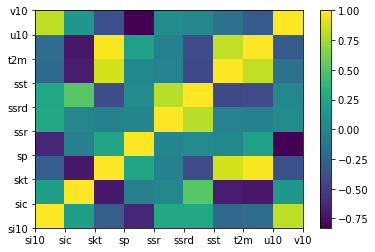

In [6]:
plt.pcolormesh(v,v,correlation_matrix.transpose())
plt.colorbar()
plt.show()

# Regressions

In [7]:
x_surface = ['si10','sp', 'ssr', 'sst','t2m','u10','v10']

regression_results = w4.multiple_fast_regression(ds, 'sic', x_surface)

Finding coefficients for ['si10', 'sp', 'ssr', 'sst', 't2m', 'u10', 'v10'] against sic


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:06<00:00, 16206.91it/s]


Predicting SIC


In [8]:
regression_results

<xarray.Dataset>
Dimensions:                                 (time: 41, x: 316, y: 332)
Coordinates:
  * time                                    (time) datetime64[ns] 1979-01-01 ...
  * y                                       (y) int32 4350000 ... -3925000
  * x                                       (x) int32 -3950000 ... 3925000
Data variables:
    sic                                     (x, y, time) float64 0.0 0.0 ... 0.0
    si10                                    (x, y, time) float64 nan ... 2.061
    sp                                      (x, y, time) float64 nan ... 0.09667
    ssr                                     (x, y, time) float64 nan ... -0.3095
    sst                                     (x, y, time) float64 nan ... -1.403
    t2m                                     (x, y, time) float64 nan ... -1.541
    u10                                     (x, y, time) float64 nan ... 2.548
    v10                                     (x, y, time) float64 nan ... -0.5285
    prediction_si10_sp_ssr_sst_t2m_u10_v10  (x, y, time) float64 nan nan ... 0.0
    regr_coef_si10                          (x, y) float64 0.0 0.0 ... 0.0 0.0
    regr_coef_sp                            (x, y) float64 0.0 0.0 ... 0.0 0.0
    regr_coef_ssr                           (x, y) float64 0.0 0.0 ... 0.0 0.0
    regr_coef_sst                           (x, y) float64 0.0 0.0 ... 0.0 0.0
    regr_coef_t2m                           (x, y) float64 0.0 0.0 ... 0.0 0.0
    regr_coef_u10                           (x, y) float64 0.0 0.0 ... 0.0 0.0
    regr_coef_v10                           (x, y) float64 0.0 0.0 ... 0.0 0.0
    regr_coef_error                         (x, y) float64 0.0 0.0 ... 0.0 0.0
    prediction_si10                         (x, y, time) float64 nan nan ... 0.0
    prediction_sp                           (x, y, time) float64 nan nan ... 0.0
    prediction_ssr                          (x, y, time) float64 nan nan ... 0.0
    prediction_sst                          (x, y, time) float64 nan nan ... 0.0
    prediction_t2m                          (x, y, time) float64 nan nan ... 0.0
    prediction_u10                          (x, y, time) float64 nan nan ... 0.0
    prediction_v10                          (x, y, time) float64 nan nan ... 0.0

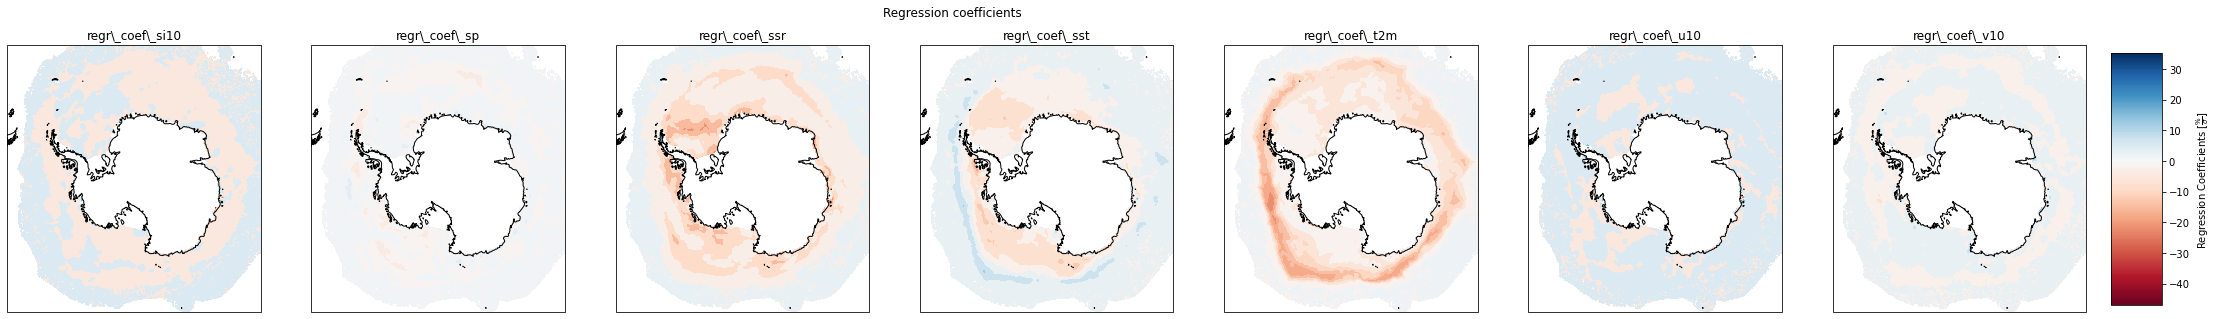

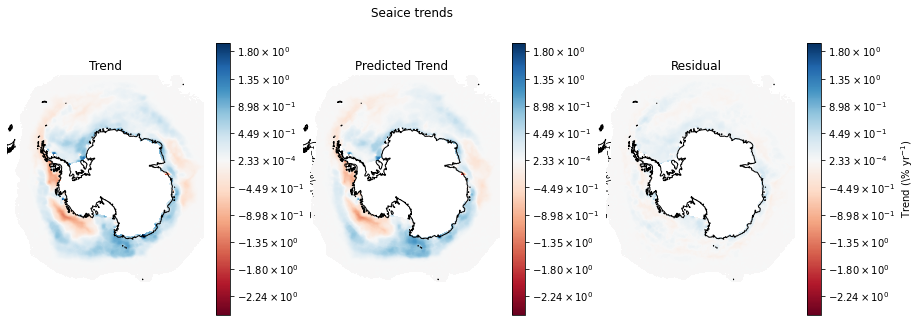

findfont: Font family ['computer modern'] not found. Falling back to DejaVu Sans.


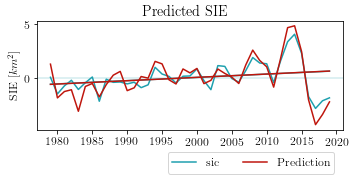

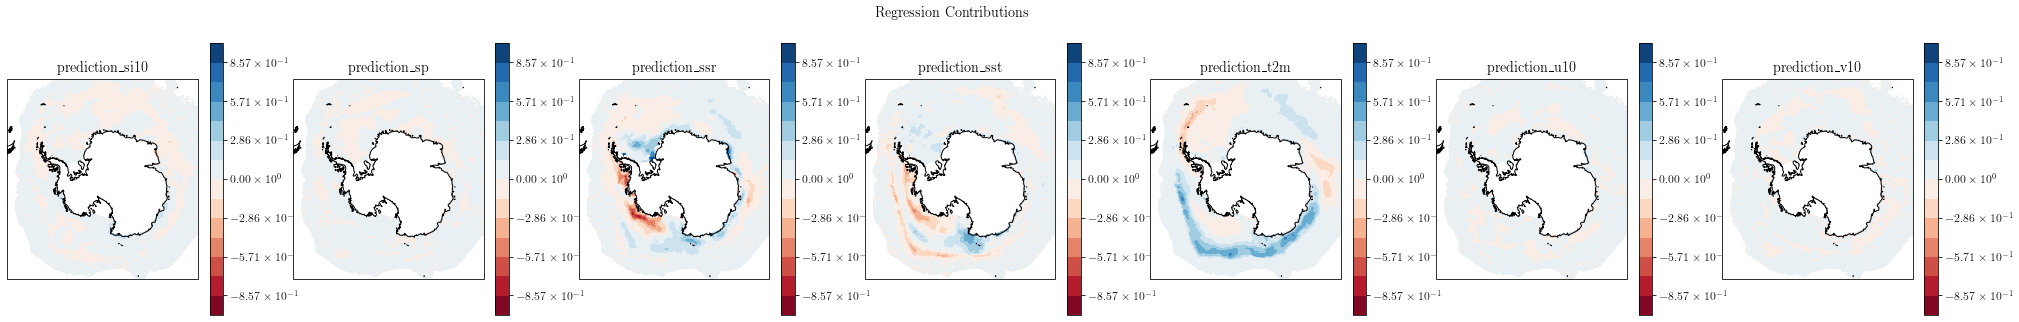

In [9]:
w5.plotting(regression_results, 'sic', x_surface)

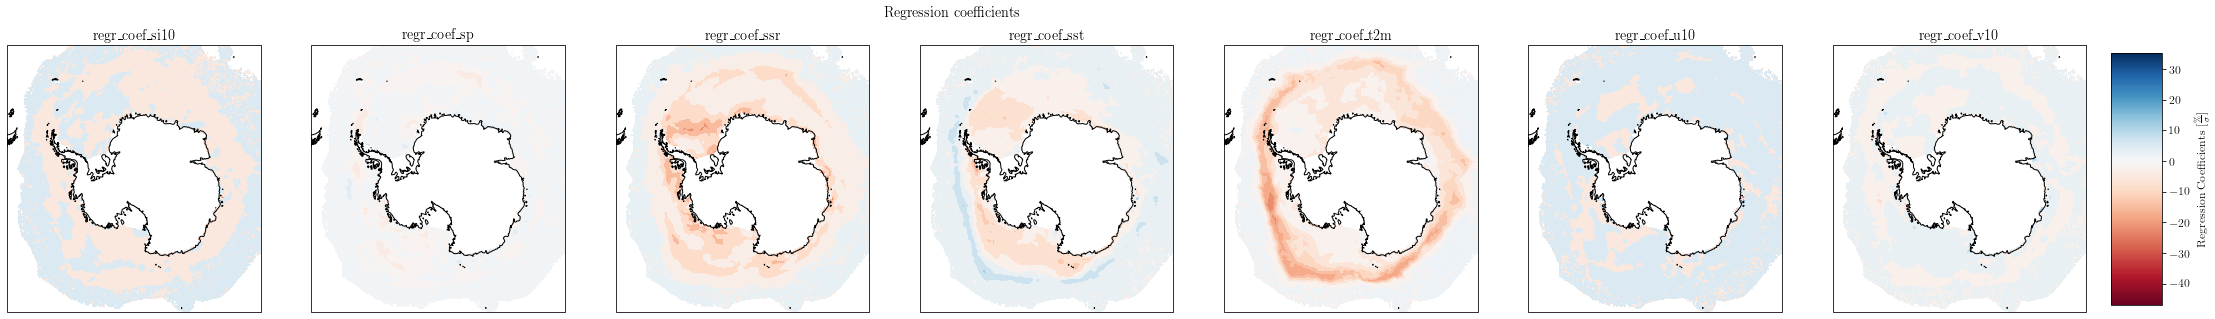

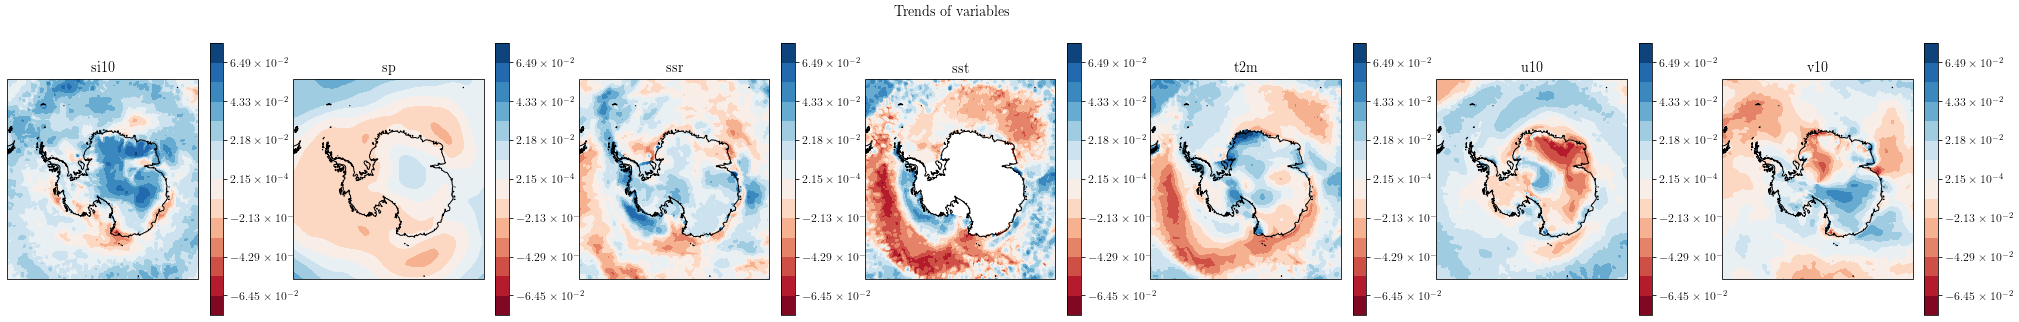

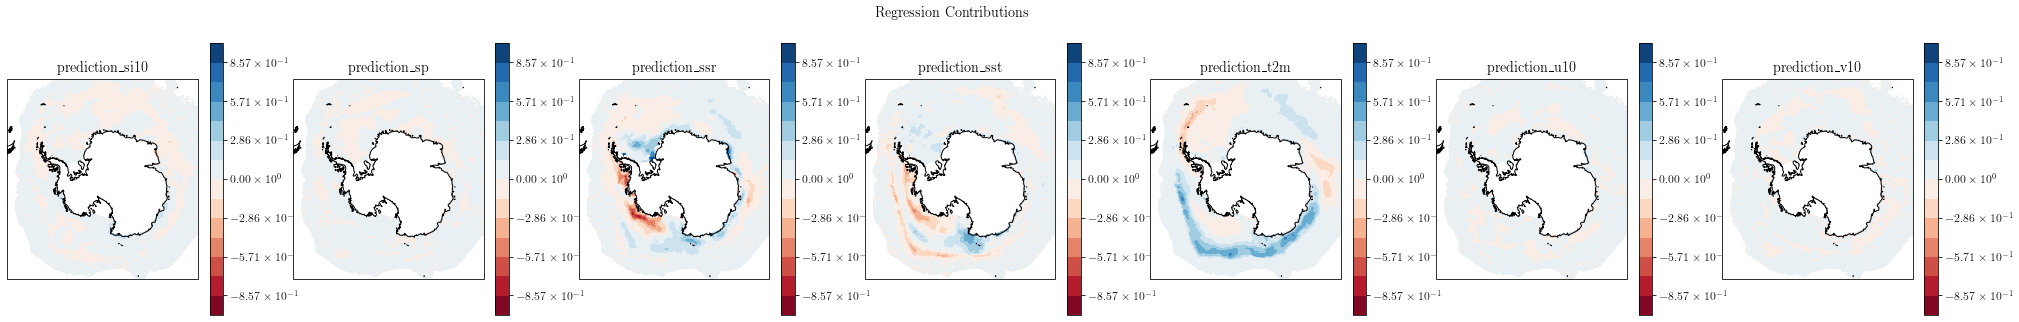

In [10]:
w5.more_plotting(regression_results, 'sic', x_surface)

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    si10     (time, y, x) float64 nan nan nan nan ... 2.163 2.142 2.112 2.061
    sp       (time, y, x) float64 nan nan nan nan ... 0.02288 0.05956 0.09667
    ssr      (time, y, x) float64 nan nan nan nan ... -0.446 -0.3994 -0.3095
    sst      (time, y, x) float64 nan nan nan nan ... -1.197 -1.23 -1.271 -1.403
    u10      (time, y, x) float64 nan nan nan nan ... 2.583 2.575 2.564 2.548
    v10      (time, y, x) float64 nan nan nan nan ... -0.5386 -0.5318 -0.5285
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.367 -0.3723 -0.3834
Finding coefficients for ['si10', 'sp', 'ssr', 'sst', 'u10', 'v10'] against t2m


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:06<00:00, 17233.46it/s]


Predicting SIC


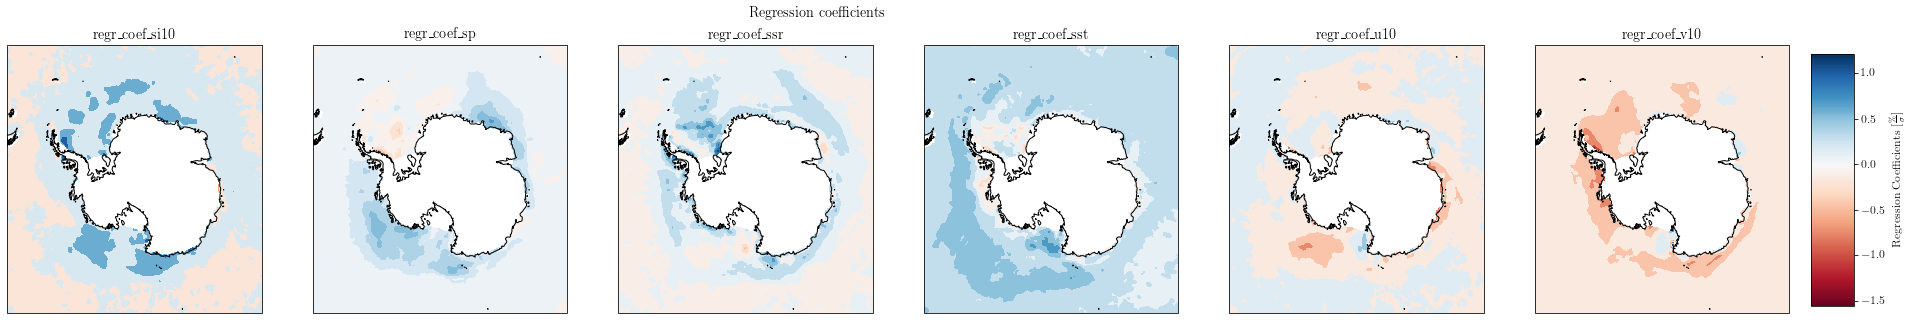

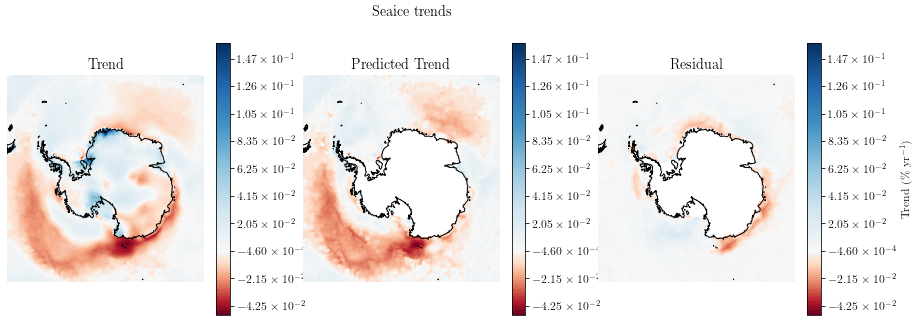

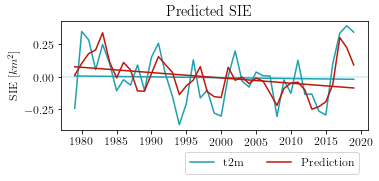

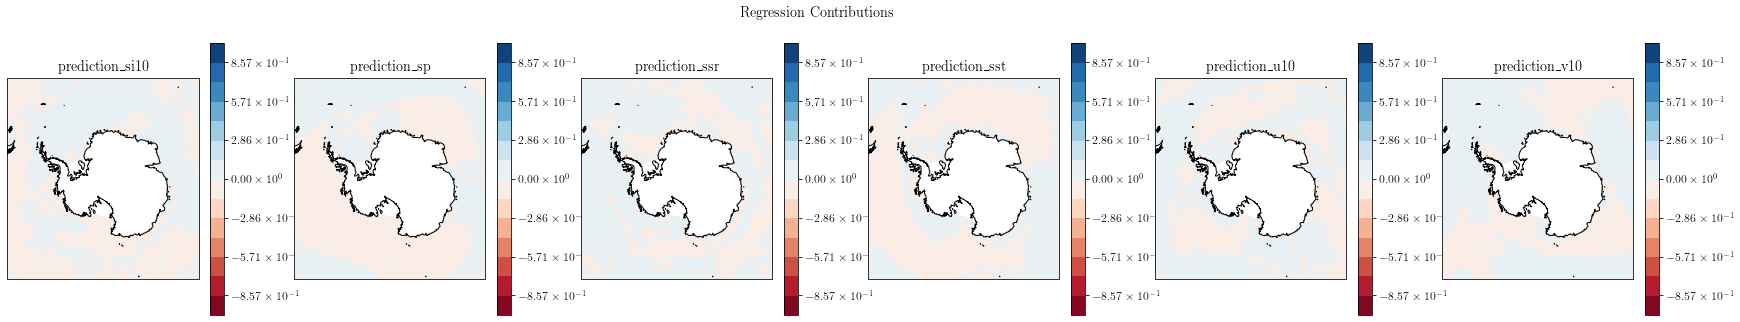

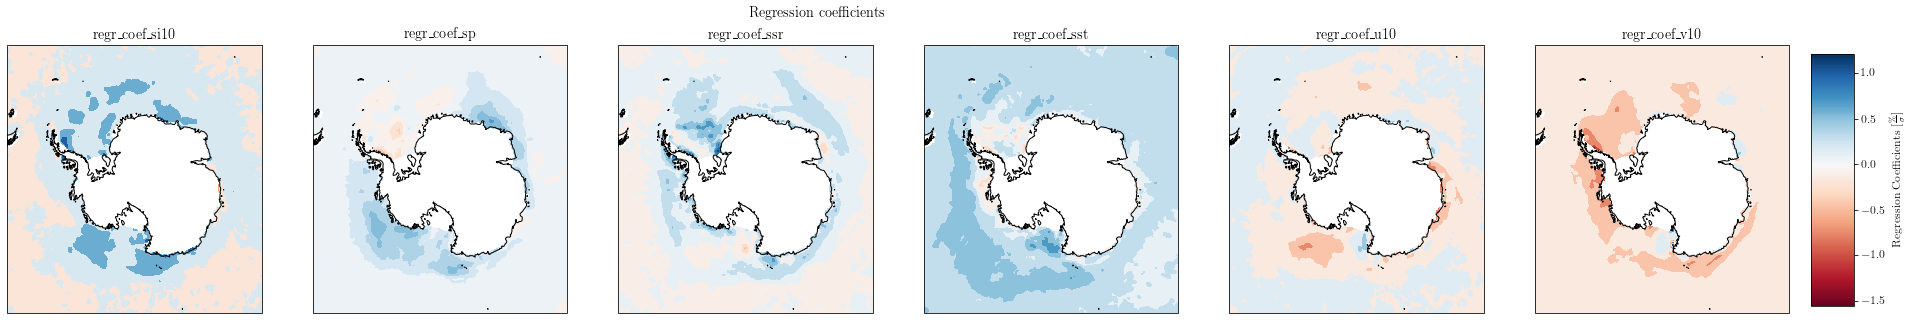

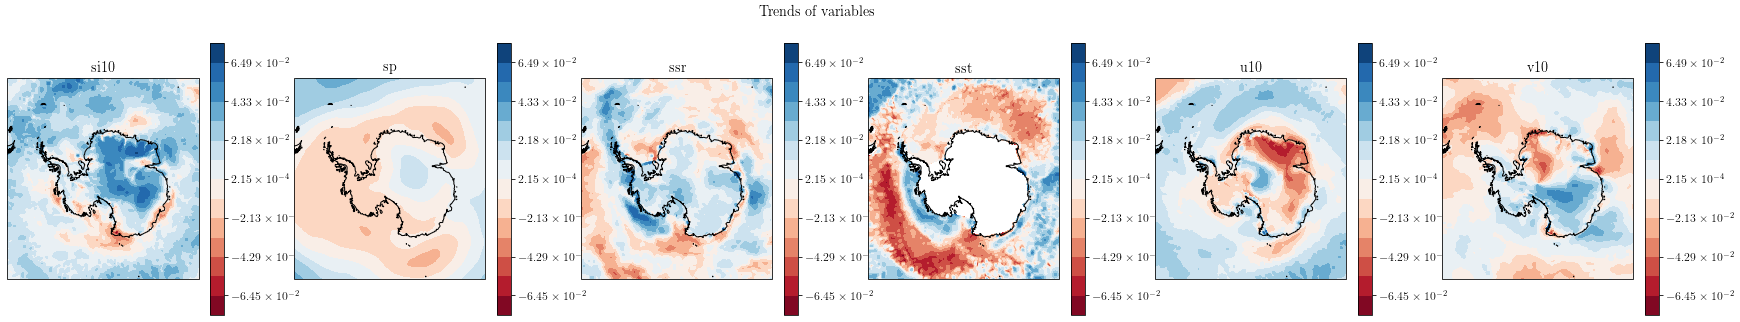

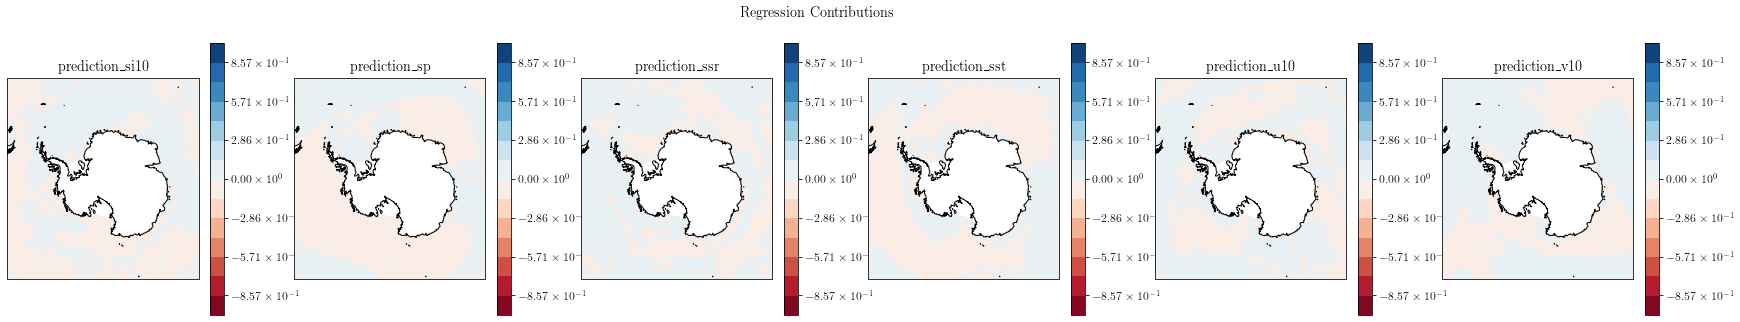

In [12]:
dependant = 't2m'
independant = ['si10','sp', 'ssr', 'sst','u10','v10']
files = glob.glob('processed_data/*')
files = [f for f in files if '_' not in f.split('\\')[1]]
ds = xr.open_mfdataset(files)

ds = ds[independant + [dependant]]

# Preprocess the data
ds = (ds
      .pipe(w5.find_anomalies)
      .pipe(w5.yearly_average)
      .pipe(w5.normalise_indepenant, dependant=dependant)
     ).compute()

ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
print(ds)

regression_results = w4.multiple_fast_regression(ds, dependant, independant)
w5.plotting(regression_results, dependant, independant)
w5.more_plotting(regression_results, dependant, independant)

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    si10     (time, y, x) float64 nan nan nan nan ... 2.163 2.142 2.112 2.061
    sp       (time, y, x) float64 nan nan nan nan ... 0.02288 0.05956 0.09667
    ssr      (time, y, x) float64 nan nan nan nan ... -0.446 -0.3994 -0.3095
    t2m      (time, y, x) float64 nan nan nan nan ... -1.457 -1.485 -1.541
    u10      (time, y, x) float64 nan nan nan nan ... 2.583 2.575 2.564 2.548
    v10      (time, y, x) float64 nan nan nan nan ... -0.5386 -0.5318 -0.5285
    sst      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.4129 -0.4279 -0.4679
Finding coefficients for ['si10', 'sp', 'ssr', 't2m', 'u10', 'v10'] against sst


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:06<00:00, 16887.58it/s]


Predicting SIC


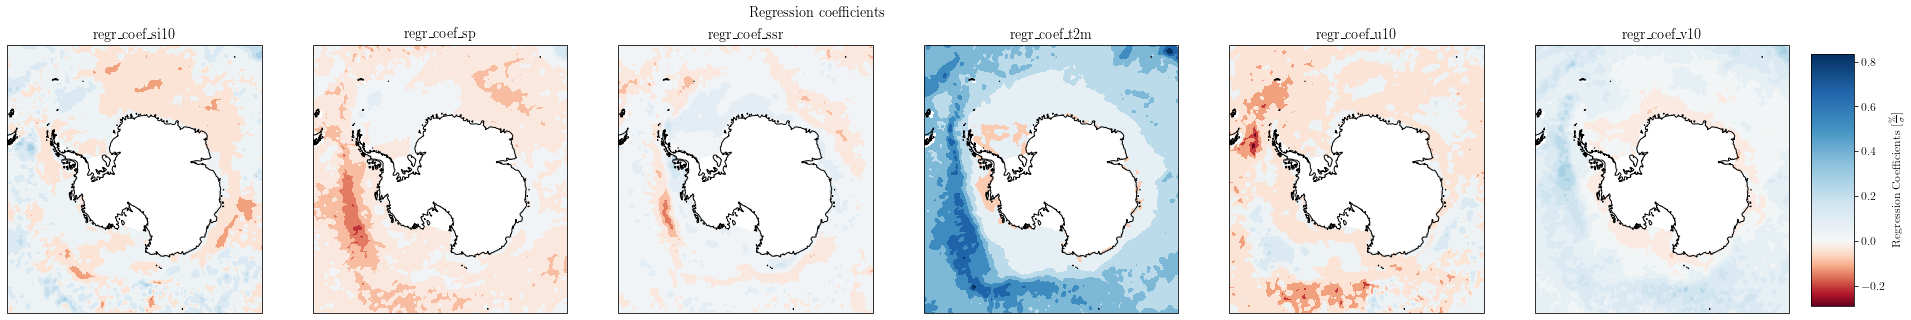

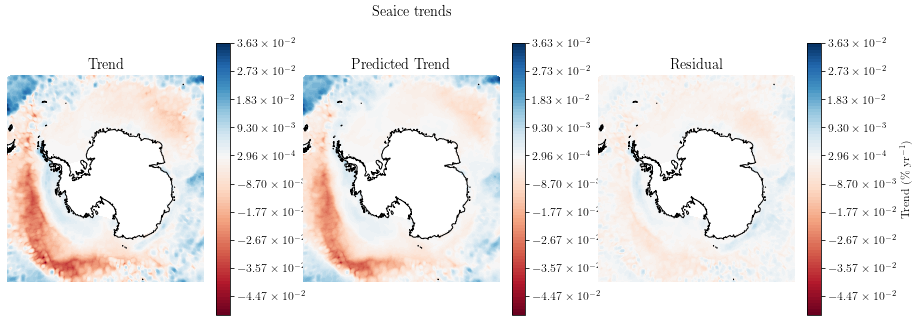

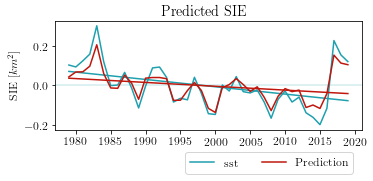

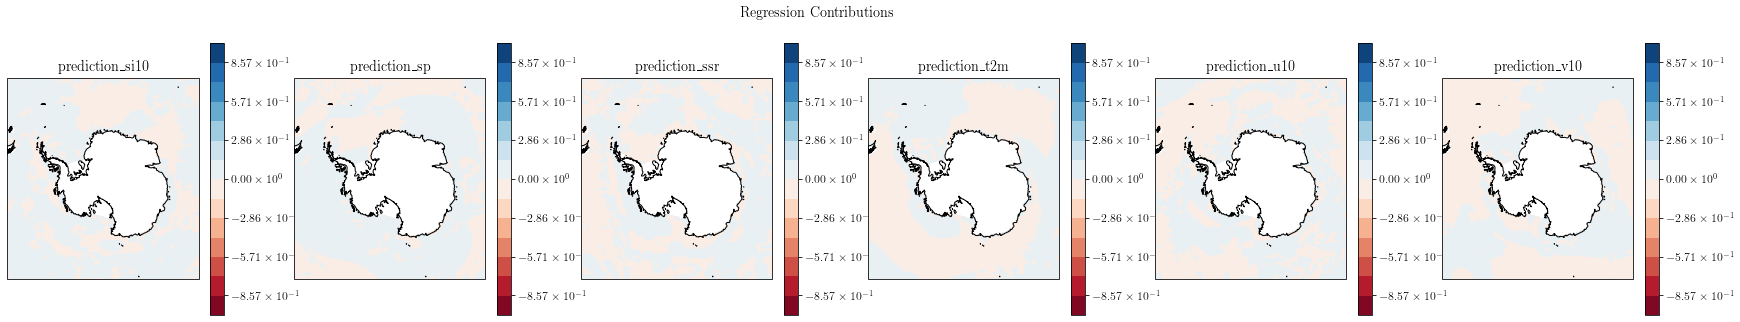

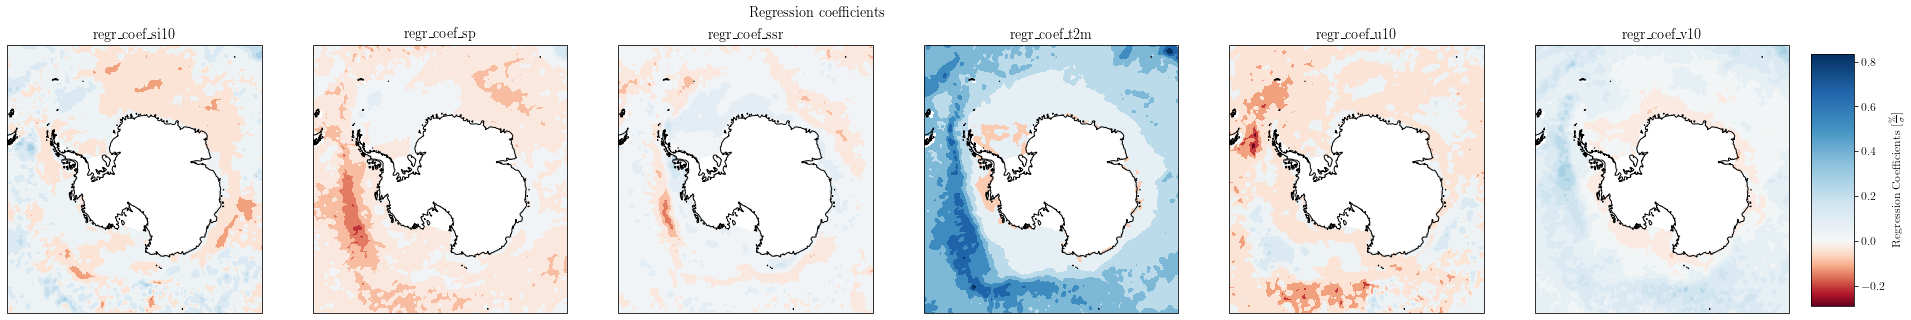

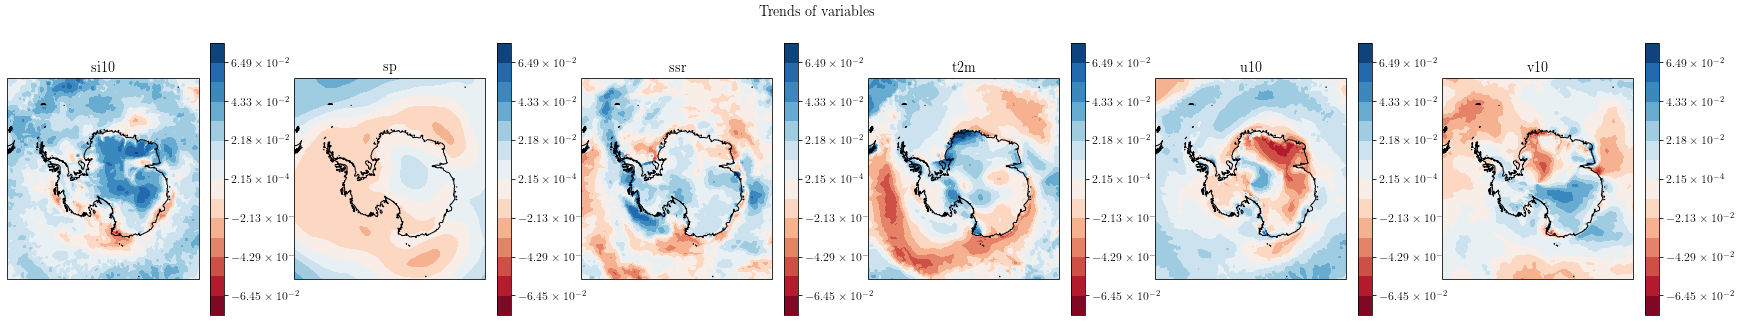

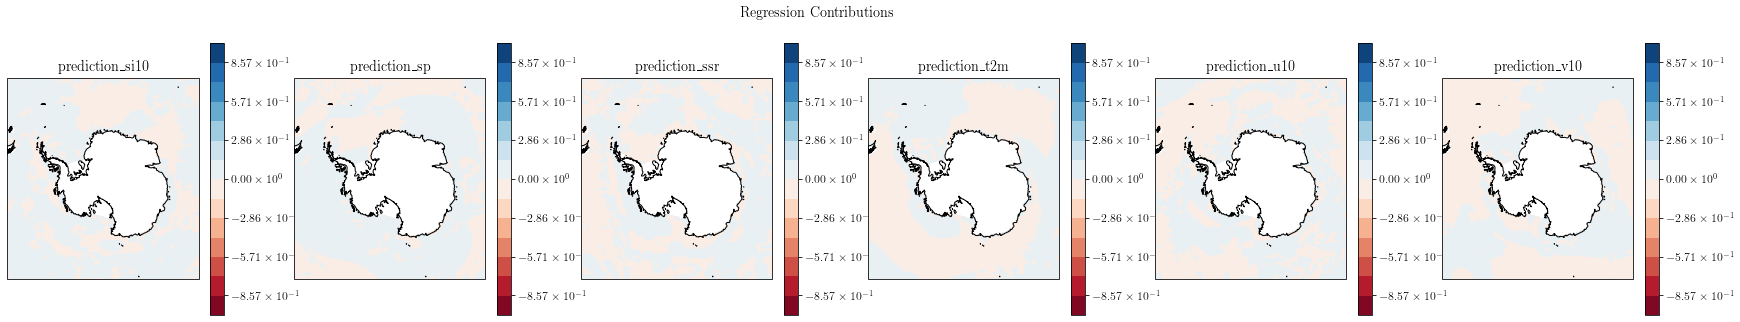

In [13]:
dependant = 'sst'
independant = ['si10','sp', 'ssr','t2m','u10','v10']
files = glob.glob('processed_data/*')
files = [f for f in files if '_' not in f.split('\\')[1]]
ds = xr.open_mfdataset(files)

ds = ds[independant + [dependant]]

# Preprocess the data
ds = (ds
      .pipe(w5.find_anomalies)
      .pipe(w5.yearly_average)
      .pipe(w5.normalise_indepenant, dependant=dependant)
     ).compute()

ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
print(ds)

regression_results = w5.multiple_fast_regression(ds, dependant, independant)

regression_results

w5.plotting(regression_results, dependant, independant)

w5.more_plotting(regression_results, dependant, independant)

In [ ]:
dependant = 'ssr'
independant = ['si10','sp', 'sst','t2m','u10','v10']
files = glob.glob('processed_data/*')
files = [f for f in files if '_' not in f.split('\\')[1]]
ds = xr.open_mfdataset(files)

ds = ds[independant + [dependant]]

# Preprocess the data
ds = (ds
      .pipe(w5.find_anomalies)
      .pipe(w5.yearly_average)
      .pipe(w5.normalise_indepenant, dependant=dependant)
     ).compute()

ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
print(ds)

regression_results = w4.multiple_fast_regression(ds, dependant, independant)
w5.plotting(regression_results, dependant, independant)
w5.more_plotting(regression_results, dependant, independant)

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    si10     (time, y, x) float64 nan nan nan nan ... 2.163 2.142 2.112 2.061
    sp       (time, y, x) float64 nan nan nan nan ... 0.02288 0.05956 0.09667
    sst      (time, y, x) float64 nan nan nan nan ... -1.197 -1.23 -1.271 -1.403
    t2m      (time, y, x) float64 nan nan nan nan ... -1.457 -1.485 -1.541
    u10      (time, y, x) float64 nan nan nan nan ... 2.583 2.575 2.564 2.548
    v10      (time, y, x) float64 nan nan nan nan ... -0.5386 -0.5318 -0.5285
    ssr      (time, y, x) float64 0.0 0.0 0.0 ... -9.102e+04 -7.263e+04
Finding coefficients for ['si10', 'sp', 'sst', 't2m', 'u10', 'v10'] against ssr


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:06<00:00, 17404.46it/s]


Predicting SIC


In [ ]:
%tb